# Nikolas Iliopoulos 1115201800332
# AI_2 Part 3

# Install Tranfsormers

In [ ]:
!pip install transformers
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dev-v2.0.json

!wget http://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
!tar xf triviaqa-rc.tar.gz

from transformers import AutoTokenizer
from transformers import DistilBertForQuestionAnswering

import torch
from torch.utils.data import TensorDataset
from torch.optim import AdamW

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc

--2022-03-13 19:06:15--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   143MB/s    in 0.3s    

2022-03-13 19:06:15 (143 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2022-03-13 19:06:16--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

# utils.py

In [ ]:
import json


def write_json_to_file(json_object, json_file, mode='w', encoding='utf-8'):
    with open(json_file, mode, encoding=encoding) as outfile:
        json.dump(json_object, outfile, indent=4, sort_keys=True, ensure_ascii=False)


def get_file_contents(filename, encoding='utf-8'):
    with open(filename, encoding=encoding) as f:
        content = f.read()
    return content


def read_json(filename, encoding='utf-8'):
    contents = get_file_contents(filename, encoding=encoding)
    return json.loads(contents)


def get_file_contents_as_list(file_path, encoding='utf-8', ignore_blanks=True):
    contents = get_file_contents(file_path, encoding=encoding)
    lines = contents.split('\n')
    lines = [line for line in lines if line != ''] if ignore_blanks else lines
    return lines

# convert_to_squad_format.py

In [ ]:
import os
from tqdm import tqdm
import random
import nltk
import argparse


def get_text(qad, domain):
    local_file = os.path.join(args.web_dir, qad['Filename']) if domain == 'SearchResults' else os.path.join(args.wikipedia_dir, qad['Filename'])
    return get_file_contents(local_file, encoding='utf-8')


def select_relevant_portion(text):
    paras = text.split('\n')
    selected = []
    done = False
    for para in paras:
        sents = sent_tokenize.tokenize(para)
        for sent in sents:
            words = nltk.word_tokenize(sent)
            for word in words:
                selected.append(word)
                if len(selected) >= args.max_num_tokens:
                    done = True
                    break
            if done:
                break
        if done:
            break
        selected.append('\n')
    st = ' '.join(selected).strip()
    return st


def add_triple_data(datum, page, domain):
    qad = {'Source': domain}
    for key in ['QuestionId', 'Question', 'Answer']:
        qad[key] = datum[key]
    for key in page:
        qad[key] = page[key]
    return qad


def get_qad_triples(data):
    qad_triples = []
    for datum in data['Data']:
        for key in ['EntityPages', 'SearchResults']:
            for page in datum.get(key, []):
                qad = add_triple_data(datum, page, key)
                qad_triples.append(qad)
    return qad_triples


def convert_to_squad_format(qa_json_file, squad_file):
    qa_json = read_triviaqa_data(qa_json_file)
    qad_triples = get_qad_triples(qa_json)

    random.seed(args.seed)
    random.shuffle(qad_triples)

    data = []
    for qad in tqdm(qad_triples):
        qid = qad['QuestionId']

        text = get_text(qad, qad['Source'])
        selected_text = select_relevant_portion(text)

        question = qad['Question']
        para = {'context': selected_text, 'qas': [{'question': question, 'answers': []}]}
        data.append({'paragraphs': [para]})
        qa = para['qas'][0]
        qa['id'] = get_question_doc_string(qid, qad['Filename'])
        qa['qid'] = qid

        ans_string, index = answer_index_in_document(qad['Answer'], selected_text)
        if index == -1:
            if qa_json['Split'] == 'train':
                continue
        else:
            qa['answers'].append({'text': ans_string, 'answer_start': index})

        if qa_json['Split'] == 'train' and len(data) >= args.sample_size and qa_json['Domain'] == 'Web':
            break

    squad = {'data': data, 'version': qa_json['Version']}
    write_json_to_file(squad, squad_file)
    print ('Added', len(data))


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--triviaqa_file', help='Triviaqa file')
    parser.add_argument('--squad_file', help='Squad file')
    parser.add_argument('--wikipedia_dir', help='Wikipedia doc dir')
    parser.add_argument('--web_dir', help='Web doc dir')

    parser.add_argument('--seed', default=10, type=int, help='Random seed')
    parser.add_argument('--max_num_tokens', default=800, type=int, help='Maximum number of tokens from a document')
    parser.add_argument('--sample_size', default=80000, type=int, help='Random seed')
    parser.add_argument('--tokenizer', default='tokenizers/punkt/english.pickle', help='Sentence tokenizer')
    args = parser.parse_args()
    return args

# dataset_utils.py

In [ ]:

# Key for wikipedia eval is question-id. Key for web eval is the (question_id, filename) tuple
def get_key_to_ground_truth(data):
    if data['Domain'] == 'Wikipedia':
        return {datum['QuestionId']: datum['Answer'] for datum in data['Data']}
    else:
        return get_qd_to_answer(data)


def get_question_doc_string(qid, doc_name):
    return '{}--{}'.format(qid, doc_name)

def get_qd_to_answer(data):
    key_to_answer = {}
    for datum in data['Data']:
        for page in datum.get('EntityPages', []) + datum.get('SearchResults', []):
            qd_tuple = get_question_doc_string(datum['QuestionId'], page['Filename'])
            key_to_answer[qd_tuple] = datum['Answer']
    return key_to_answer


def read_clean_part(datum):
    for key in ['EntityPages', 'SearchResults']:
        new_page_list = []
        for page in datum.get(key, []):
            if page['DocPartOfVerifiedEval']:
                new_page_list.append(page)
        datum[key] = new_page_list
    assert len(datum['EntityPages']) + len(datum['SearchResults']) > 0
    return datum


def read_triviaqa_data(qajson):
    data = read_json(qajson)
    # read only documents and questions that are a part of clean data set
    if data['VerifiedEval']:
        clean_data = []
        for datum in data['Data']:
            if datum['QuestionPartOfVerifiedEval']:
                if data['Domain'] == 'Web':
                    datum = read_clean_part(datum)
                clean_data.append(datum)
        data['Data'] = clean_data
    return data


def answer_index_in_document(answer, document):
    answer_list = answer['NormalizedAliases']
    for answer_string_in_doc in answer_list:
        index = document.lower().find(answer_string_in_doc)
        if index != -1:
            return answer_string_in_doc, index
    return answer['NormalizedValue'], -1


# scrypt to convert TriviaQA into SQUAD2 format

In [ ]:
import os
import argparse
import json
import nltk
nltk.download('punkt')


def answer_index_in_document(answer, document):
    answer_list = answer['Aliases'] + answer['NormalizedAliases']
    for answer_string_in_doc in answer_list:
        index = document.find(answer_string_in_doc)
        if index != -1:
            return answer_string_in_doc, index
    return answer['NormalizedValue'], -1


def select_relevant_portion(text):
    paras = text.split('\n')
    selected = []
    done = False
    for para in paras:
        sents = sent_tokenize.tokenize(para)
        for sent in sents:
            words = nltk.word_tokenize(sent)
            for word in words:
                selected.append(word)
                if len(selected) >= 800:
                    done = True
                    break
            if done:
                break
        if done:
            break
        selected.append('\n')
    st = ' '.join(selected).strip()
    return st


def triviaqa_to_squad_format(triviaqa_file, data_dir, output_file):
    triviaqa_json = read_triviaqa_data(triviaqa_file)
    qad_triples = get_qad_triples(triviaqa_json)

    data = []

    for triviaqa_example in qad_triples:
        question_text = triviaqa_example['Question']
        text = get_file_contents(os.path.join(data_dir, triviaqa_example['Filename']), encoding='utf-8')
        context = select_relevant_portion(text)

        para = {'context': context, 'qas': [{'question': question_text, 'answers': []}]}
        data.append({'paragraphs': [para]})
        qa = para['qas'][0]
        qa['id'] = get_question_doc_string(triviaqa_example['QuestionId'], triviaqa_example['Filename'])
        qa['is_impossible'] = True
        ans_string, index = answer_index_in_document(triviaqa_example['Answer'], context)

        if index != -1:
            qa['answers'].append({'text': ans_string, 'answer_start': index})
            qa['is_impossible'] = False

    triviaqa_as_squad = {'data': data, 'version': '2.0'}

    with open(output_file, 'w', encoding='utf-8') as outfile:
        json.dump(triviaqa_as_squad, outfile, indent=2, sort_keys=True, ensure_ascii=False)



sent_tokenize = nltk.data.load('tokenizers/punkt/english.pickle')

triviaqa_to_squad_format("qa/wikipedia-train.json", "evidence/wikipedia/", "triviaqa_train.json")

triviaqa_to_squad_format("qa/wikipedia-dev.json", "evidence/wikipedia/", "triviaqa_dev.json")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Functions for computing F1

In [ ]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return 2 * (prec * rec) / (prec + rec)

def normalize_text(s):
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# define Trainer

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, answers):
        self.encodings = encodings
        self.answers = answers
        
    def __getitem__(self, index):
        item = {}
        for key, val in self.encodings.items():
            item[key] = torch.tensor(val[index])
        item['answer'] = self.answers[index]
        return item

    def __len__(self):
        return len(self.answers)

class MyTrainer():
    def __init__(self, lr, epochs, batchSize):
        print("__init__()")
        self.lr = lr
        self.epochs = epochs
        self.batchSize = batchSize
        self.maxLength = 512
        self.model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.optimizer = AdamW(self.model.parameters(),
                        lr=self.lr,
                        eps=1e-8)
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        print("maxLength=",self.maxLength)
        print("Device=",self.device)
        if self.use_cuda:
            # LOAD THE MODEL TO THE GPU
            self.model = self.model.cuda()
            print('GPU Model', torch.cuda.get_device_name(0))

    def processData(self, data, reduceSizeOfData):
        print("processData()")
        self.texts, self.queries, self.answers = [], [], []

        for d in data['data']:
            for paragraph in d['paragraphs']:
                context = paragraph['context']
                for qas in paragraph['qas']:
                    question = qas['question']
                    for answer in qas['answers']:
                        self.texts.append(context)
                        self.queries.append(question)
                        self.answers.append(answer)

        for answer, text in zip(self.answers,self.texts):
            indexStart = answer['answer_start']
            indexEnd = indexStart + len(answer['text'])
            
            if text[indexStart:indexEnd] == answer['text']:
                answer['answer_end']   = indexEnd
            elif text[ indexStart-1 : indexEnd-1 ] == answer['text']:
                answer['answer_start'] = indexStart - 1
                answer['answer_end']   = indexEnd   - 1  
            elif text[ indexStart-2 : indexEnd-2 ] == answer['text']:
                answer['answer_start'] = indexStart - 2
                answer['answer_end']   = indexEnd   - 2  
        if reduceSizeOfData:
            self.texts = self.texts[:50000]
            self.queries = self.queries[:50000]
            self.answers = self.answers[:50000]
    
    def prepareInputs(self):
        print("prepareInputs()")

        out = self.tokenizer(self.texts,
                                self.queries,
                                truncation=True,
                                padding=True)
                                
        startIndex, endIndex = [], []

        count = 0

        for i in range(len(self.answers)):
          startIndex.append(out.char_to_token(i, self.answers[i]['answer_start']))
          endIndex.append(out.char_to_token(i, self.answers[i]['answer_end']))

          # if start position is None, the answer passage has been truncated
          if startIndex[-1] is None:
            startIndex[-1] = self.tokenizer.model_max_length
            
          # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
          if endIndex[-1] is None:
            endIndex[-1] = out.char_to_token(i, self.answers[i]['answer_end'] - 1)
            # if end position is still None the answer passage has been truncated
            if endIndex[-1] is None:
              count += 1
              endIndex[-1] = self.tokenizer.model_max_length

        # Update the data in dictionary
        out.update({'startIndex': startIndex, 'endIndex': endIndex})

        self.dataloader_train = torch.utils.data.DataLoader(MyDataset(out,self.answers), batch_size=self.batchSize, shuffle=True)
    def train(self):
         totalSteps = len(self.dataloader_train)
         n_epoch=0
         self.iters = []
         self.losses = []

         self.model.train()
         for epoch in range(self.epochs):
            batch_losses = []

            # TRAINING
            for batch in tqdm(self.dataloader_train):
                # LOAD THE DATA TO THE GPU
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                startIndex  = batch['startIndex'].to(self.device)
                endIndex   = batch['endIndex'].to(self.device)
                answer = batch['answer']['text']
      
                self.model.zero_grad()

                outputs = self.model(input_ids, attention_mask=attention_mask, start_positions=startIndex,end_positions=endIndex)
                loss = outputs.loss
                
                # store the loss of that batch
                batch_losses.append(loss.item())
                # BackwardPropagation to calculate the gradients.
                loss.backward()
                # Clip Gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                # Update parameters
                self.optimizer.step()

                n_epoch+=1

            self.losses.append(sum(batch_losses)/len(self.dataloader_train))
            self.iters.append(n_epoch)

            print("Loss:    ", sum(batch_losses)/len(self.dataloader_train))

    def validate(self,data_Val):
        self.model.eval()
        self.f1_Val = []
        self.val_iters = 0
        for group in tqdm(data_Val['data']):
            for passage in group['paragraphs']:
                context = passage['context']
                for qa in passage['qas']:
                    question = qa['question']
                    for answer in qa['answers']:
#                         text - > context
                        tokens = self.tokenizer.encode_plus(context, question, truncation=True, return_tensors = 'pt')
                        tokens.to(self.device)
                        outputs = self.model(**tokens)
                        startIndex_pred = torch.argmax(outputs.start_logits)
                        endIndex_pred = torch.argmax(outputs.end_logits) + 1
                        answer_pred = self.tokenizer.convert_tokens_to_string(self.tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][startIndex_pred:endIndex_pred]))
                        f1 = compute_f1(answer_pred,answer['text'])
                        self.f1_Val.append(f1)
                        self.val_iters += 1
                        
                        
    def plot(self):
        plt.title("Learning Curve")
        plt.plot(self.iters, self.losses, label="Train Loss")
        plt.xlabel("Iteration(Epoch)")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
        print('F1 ',sum(self.f1_Val)/self.val_iters)


# Check the FineTuned on SQUAD2 model on the SQUAD2 validation dataset

In [ ]:
# reading the training json of SQOUAD
data = pd.read_json('./train-v2.0.json')
# reading the validation json of SQUAD
data_Val = pd.read_json('./dev-v2.0.json')

trainerSQUAD = MyTrainer(2e-5, 2, 16)
trainerSQUAD.processData(data, False)
trainerSQUAD.prepareInputs()
trainerSQUAD.train()
trainerSQUAD.validate(data_Val)
trainerSQUAD.plot()

# Check the FineTuned on SQUAD2 model on the TriviaQA validation dataset

In [ ]:
# reading the validation json of TRIVIAQA
data_Val = pd.read_json('./triviaqa_dev.json')

trainerSQUAD.validate(data_Val)
trainerSQUAD.plot()

processData()
prepareInputs()


# Check the FineTuned on TriviaQA model on the SQUAD2 validation dataset

__init__()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

maxLength= 512
Device= cuda
GPU Model Tesla P100-PCIE-16GB
processData()
prepareInputs()


100%|██████████| 3125/3125 [23:02<00:00,  2.26it/s]


Loss:     2.676206574420929


100%|██████████| 3125/3125 [23:00<00:00,  2.26it/s]


Loss:     1.6205137833213805


100%|██████████| 35/35 [02:17<00:00,  3.92s/it]


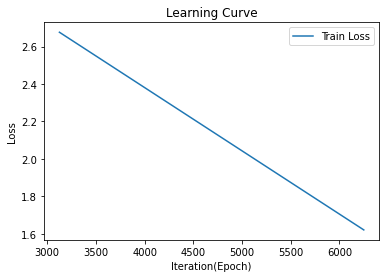

F1  0.24337300647754442


In [ ]:
# reading the training json of TRIVIAQA
data = pd.read_json('./triviaqa_train.json')
# reading the validation json of SQOUAD
data_Val = pd.read_json('./dev-v2.0.json')

trainerTrivia = MyTrainer(2e-5, 2, 16)
trainerTrivia.processData(data, True)
trainerTrivia.prepareInputs()
trainerTrivia.train()
trainerTrivia.validate(data_Val)
trainerTrivia.plot()

# Check the FineTuned on TriviaQA model on the TriviaQA validation dataset

100%|██████████| 14229/14229 [02:18<00:00, 102.92it/s]


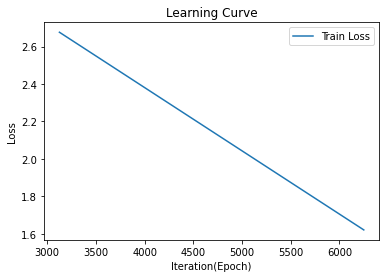

F1  0.4556296653956149


In [ ]:
# reading the validation json of TRIVIAQA
data_Val = pd.read_json('./triviaqa_dev.json')

trainerTrivia.validate(data_Val)
trainerTrivia.plot()